# Classification Models Inference

In [ ]:
# LIBRARIES
import torch
from torchvision import models
import numpy as np
import scipy as sp
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import requests
from io import BytesIO

In [ ]:
# MODELS

# Load all models in init.py and keep them loaded
#alexnet = models.alexnet(pretrained=True)  # 216 Mb
#resnet18 = models.resnet18(pretrained=True) # 45 Mb
squeezenet1_1 = models.squeezenet1_1(pretrained=True) # 4.7 Mb
#densenet161 = models.densenet161(pretrained=True) # 110 Mb
#efficientnet_b0 = models.efficientnet_b0(pretrained=True) # 16 Mb
#googlenet = models.googlenet(pretrained=True) # 50 Mb
#mobilenet_v2 = models.mobilenet_v2(pretrained=True) # 13.6 Mb
#vgg19 = models.vgg19(pretrained=True) # 548 Mb

In [ ]:
# PARAMETERS
available_models = [
#    'alexnet',
#    'resnet18',
    'squeezenet1_1',
#    'densenet161', 
#    'efficientnet_b0',
#    'googlenet',
#    'mobilenet_v2',
#    'vgg19'
]

In [ ]:
# FUNCTIONS

def validate_model_avaliability(net_chosen):
    '''Validate Model Availability
    It checks if the model chosen is available

    Parameters
    ----------
    net_chosen (str): Name of the chosen model

    Returns
    -------
    None (is an assertion)
    '''
    assert_message = f"'{net_chosen}' no está entre los modelos disponibles.\nModelos disponibles: \n{available_models}"
    assert net_chosen in available_models,  assert_message

def load_model(net_chosen):
    '''Load Model
    Selects the image classification model with pretrained weights. 
    It should already be loaded.

    Parameters
    ----------
    net_chosen (str): Name of the chosen model

    Returns
    -------
    net (model): Instance of the classification model
    '''
    validate_model_avaliability(net_chosen) # Assertion
    net = eval(net_chosen)
    net.eval()

    net_name = str(net.__class__).replace("'>","").split('.')[-1]
    print(f'{net_name} ha sido elegido')
    return net

def get_imagenet_labels():
    '''Get ImageNet Labels
    Gets a list of the 1000 clases of ImageNet. 
    '''
    # Imagenet Classes
    imagenet_classes_url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
    imagenet_classes = eval(requests.get(imagenet_classes_url).text)

    labels = list(imagenet_classes.values())
    return labels

def load_img(img_path):
    '''Load Image
    Loads an image from a URL or a Local Path.

    Parameters
    ----------
    img_path (str): URL or Local Path of the image

    Returns
    -------
    img (np.array): Image loaded in numpy array format
    '''
    try: # Load from internet url
        response = requests.get(img_path)
        bytes_img = BytesIO(response.content)
        print('Image loaded from internet URL')
    except: # Load from local path
        bytes_img = img_path
        print('Image loaded from local path')
        
    img = Image.open(bytes_img)
    img = np.array(img)
#    plt.imshow(img)
    return img

def preprocess_image(img):
    '''Preprocess Image
    Preprocess the Image into a format accepted by the Models

    Parameters
    ----------
    img (np.array): Image in numpy array

    Returns
    -------
    batch_t (torch.Tensor): Normalized Image in a batch format
    '''
    transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])])
    img_t = transform(img)
    batch_t = img_t.unsqueeze(0)
    return batch_t

def get_top_predictions(net, batch_t, n_top_pred=10):
    '''Get Top Predictions
    Returns the top likely predictions of the model.

    Parameters
    ----------
    net (model): Instance of the classification model
    batch_t (torch.Tensor): Normalized Image in a batch format
    
    Returns
    -------
    top_pred_df (pd.DataFrame): Df with the top predictions and their confidence
    '''
    out = net(batch_t)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    labels = get_imagenet_labels()

    _, indices = torch.sort(out, descending=True)
    top_pred = [(labels[idx], percentage[idx].item()) for idx in indices[0][:n_top_pred]]
    top_pred_df = pd.DataFrame(top_pred, columns=['class','confidence'])

    return top_pred_df

def inference_pipeline(net_chosen, img_path, n_top_pred=10):
    '''Inference Pipeline
    Complete Pipeline that selects the model, loads and preprocess the image 
    and returns the predictions. 

    Parameters
    ----------
    net_chosen (str): Name of the chosen model
    img_path (str): URL or Local Path of the image
    
    Returns
    -------
    top_pred_df (pd.DataFrame): Df with the top predictions and their confidence
    '''
    net = load_model(net_chosen)
    img = load_img(img_path)
    batch_t = preprocess_image(img)
    top_pred = get_top_predictions(net=net, batch_t=batch_t, n_top_pred=n_top_pred)
    return top_pred

In [ ]:
url_bee1 ='https://media.wired.com/photos/5bb532b7f8a2e62d0bd5c4e3/1:1/w_1800,h_1800,c_limit/bee-146810332.jpg'
url_bear1 = 'https://i.guim.co.uk/img/media/a755adc8dead2440d5ac448a289c6592e176afe8/0_90_5184_3110/master/5184.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=3fb2bcec8ce12ed3214dcc8eccb663bc'
url_bear2 = 'https://www.buildabear.com/on/demandware.static/-/Sites-buildabear-master/default/dw2b81d8a7/28502x.jpg'
url_crown1 = 'https://5.imimg.com/data5/LF/FV/HP/SELLER-54340532/full-pageant-pink-stone-crown-500x500.jpg'
url_zebra1 = 'https://res.cloudinary.com/dk-find-out/image/upload/q_80,w_1920,f_auto/DCTM_Penguin_UK_DK_AL458223_sjvgvt.jpg'
url_zebra2 = 'https://www.treehugger.com/thmb/65hcMmCLV2Y9sNc6BS61MGu_ETg=/2121x1193/smart/filters:no_upscale()/GettyImages-1043597638-49acd69677d7442588c1d8930d298a59.jpg'
url_paiche1 = 'https://lh3.googleusercontent.com/proxy/ok2pOLF8nJPhY8Tkwxl6kg2XaGjVDtC7w-btPvUzA5j3lG1DD-ytI2yj5hFOu6drYBO1nzyiiC4yNHZMrqwgQL9CTt-Mbgo_EDd57w'
url_llama1 = 'https://www.lavanguardia.com/files/content_image_mobile_filter/uploads/2020/12/29/5feafd06dfba4.jpeg'
url_bike1 = 'https://i.pinimg.com/originals/fe/0b/5e/fe0b5ef57990ab5418f022afe736ea96.jpg'
url_person1 = 'https://thumbs.dreamstime.com/b/happy-person-portrait-smiling-woman-tanned-skin-curly-hair-happy-person-portrait-smiling-young-friendly-woman-197501184.jpg'
url_coockies_chihuahua1 = 'https://miro.medium.com/max/615/1*DGDcAQmm0e0kW_1iON1e-Q.jpeg'

In [ ]:
top_preds = inference_pipeline(net_chosen='squeezenet1_1', 
                   img_path=url_bike1
                   )

SqueezeNet ha sido elegido
Image loaded from internet URL


In [ ]:
# Top prediction
top_value = top_preds.head(1).set_index('class')['confidence'].to_dict()
top_value

{'mountain bike, all-terrain bike, off-roader': 99.32002258300781}

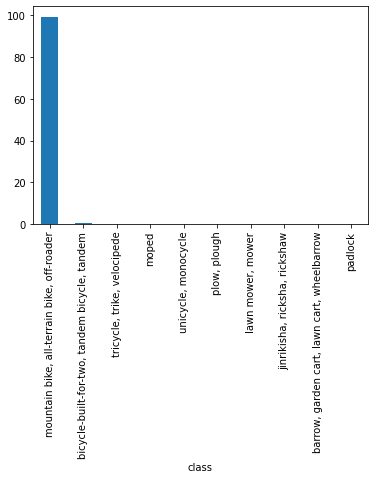

In [ ]:
top_preds.set_index(['class'])['confidence'].plot(kind='bar')